In [17]:
import numpy as np
import cPickle as pickle
import gym
import matplotlib.pyplot as plt

H = 10
learning_rate = 2e-3
gamma = 0.99
decay_rate = 0.99
score_queue_size = 100
resume = False
D = 3

In [18]:
if resume:  model = pickle.load(open('save.p', 'rb'))
else:
    model = {}
    model['W1'] = np.random.randn(H,D) / np.sqrt(D)
    model['W2'] = np.random.randn(H) / np.sqrt(H)

grad_buffer = { k : np.zeros_like(v) for k,v in model.iteritems() }
rmsprop_cache = { k : np.zeros_like(v) for k,v in model.iteritems() }

In [19]:
def sigmoid(x): 
    return 1.0 / (1.0 + np.exp(-x))

In [20]:
def prepro(I):
    return I[1:]

In [21]:
def discount_rewards(r):
    # r과 같은 size의 벡터를 만들고 0으로 Initialize
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(xrange(0, r.size)):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
        
    return discounted_r

In [22]:
def policy_forward(x):
    #Layer는 2개. h는 Hidden Layer
    #dot: Matrix의 내적. 즉 여기선 h = Wx
    h = np.dot(model['W1'], x)
    h = sigmoid(h)
    
    #굳이 output layer의 결과를 logp로 쓴 이유가 있나..?
    logp = np.dot(model['W2'], h)
    p = sigmoid(logp)
    
    # 굳이 Hidden Layer의 값 까지 return 하는 이유가 있을까? - Back propagation을 위해서
    return p, h

In [23]:
def policy_backward(eph, epdlogp, epx):
    global grad_buffer
    # ravel: reshape 함수와 같다.
    dW2 = np.dot(eph.T, epdlogp).ravel()
    dh = np.outer(epdlogp, model['W2'])
    eph_dot = eph*(1-eph)
    dW1 = dh * eph_dot
    dW1 = np.dot(dW1.T, epx)

    for k in model: grad_buffer[k] += {'W1':dW1, 'W2':dW2}[k]

In [24]:
env = gym.make('CartPole-v0')
#env.monitor.start('CartPole', force=True)
observation = env.reset()
reward_sum, episode_num = 0,0
xs,hs,dlogps,drs = [],[],[],[]
score_queue = []
rList = []

[2017-07-25 15:18:20,143] Making new env: CartPole-v0


In [ ]:
#아마도 이 샘플 코드는 Monte-Carlo Policy Gradient REINFORCE가 아닐까 싶음 - Episode Based
while True:
    
    x = prepro(observation)
    # Layer를 통과시킴 act_prob는 Action의 추정값
    act_prob, h = policy_forward(x)
    
    # Score Queue 는 100개의 최신 점수를 나타냄. 이 점수의 Mean이 180을 넘으면 Action을 반반의 확률로, 아니면 랜덤하게
    if np.mean(score_queue) > 180:
        action = 1 if 0.5 < act_prob else 0
    else:
        action = 1 if np.random.uniform() < act_prob else 0

    # 저장 x, h, action -> xs, hs, y
    xs.append(x)
    hs.append(h)
    y = action
    # dlogps: derivative of logps
    dlogps.append(y - act_prob)
    
    # 고른 Action을 하고 나서의 State, Reward 등의 정보
    observation, reward, done, info = env.step(action)
    
    # 한 Episode동안 받는 Reward를 모두 합함
    reward_sum += reward
    
    drs.append(reward)
    
    if done:
        episode_num += 1
        
        # 아직 100개가 안되었으면 그냥 저장하고, 100개 넘으면 뒤에꺼 pop, 그리고 저장 (100개 유지)
        if episode_num > score_queue_size:
            score_queue.append(reward_sum)
            score_queue.pop(0)
        else:
            score_queue.append(reward_sum)
        
        print "episode : " + str(episode_num) + ", reward : " + str(reward_sum) + ", reward_mean : " + str(np.mean(score_queue))
        rList.append(reward_sum)
        if np.mean(score_queue) >= 200:
            print "CartPole solved!!!!!"
            break
        
        # np.vstack: 열 벡터로 바꿔줌
        epx = np.vstack(xs)
        eph = np.vstack(hs)
        epdlogp = np.vstack(dlogps)
        epr = np.vstack(drs)
        xs,hs,dlogps,drs = [],[],[],[]
        
        # Normalize Z = (X - m)/sigma. - Advantage Function
        discounted_epr = discount_rewards(epr)
        discounted_epr -= np.mean(discounted_epr)
        discounted_epr /= np.std(discounted_epr)
        
        # Advantage Function에 Error를 곱해줌
        epdlogp *= discounted_epr
        
        # Backpropagation. Gradient를 계산해 buffer에 저장해둔다.
        policy_backward(eph,epdlogp,epx)
        for k,v in model.iteritems():
            g = grad_buffer[k] 
            rmsprop_cache[k] = decay_rate * rmsprop_cache[k] + (1 - decay_rate)*g**2
            model[k] += learning_rate * g / (np.sqrt(rmsprop_cache[k]) + 1e-5)
            grad_buffer[k] = np.zeros_like(v)
        
        if episode_num % 1000 == 0: pickle.dump(model, open('Cart.p', 'wb'))
        
        reward_sum = 0
        observation = env.reset()
        

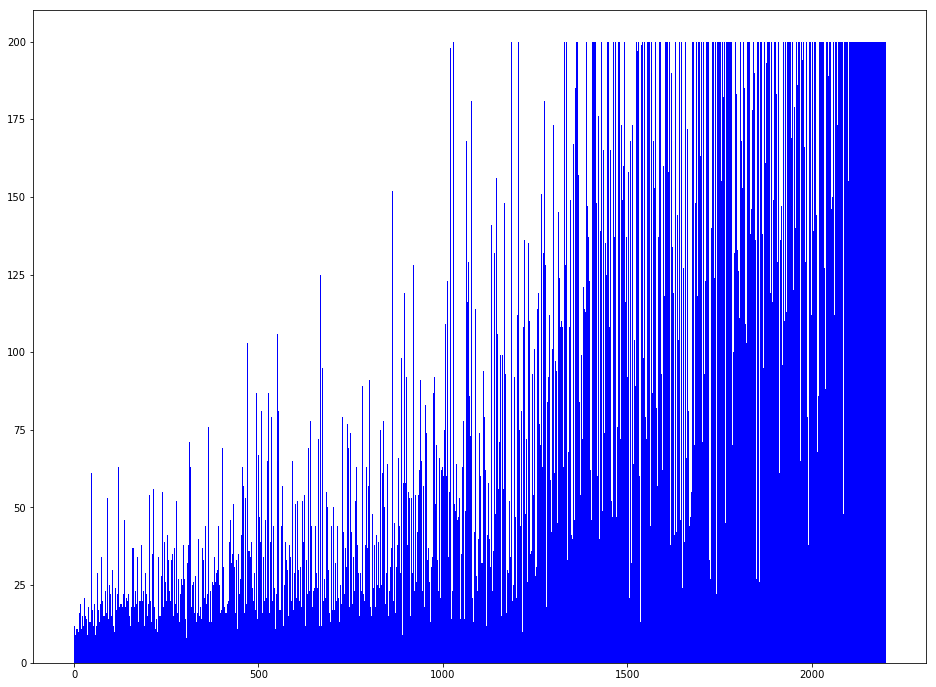

In [26]:
plt.bar(range(len(rList)), rList, color = "blue", width = 1)
figure = plt.gcf()
figure.set_size_inches(16, 12)
plt.show()